# Intuit Quickbooks Upgrade

* Team-lead GitLab userid: yil012
* Group name: Anaconda
* Team member names: Yinluo Li, Yuquan Zheng, Zezheng Hao, Shangfu Chen

In [1]:
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns

warnings.filterwarnings("ignore")


import statsmodels.formula.api as smf
from sklearn.ensemble import (
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from utils import functions
from xgboost import XGBClassifier

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k_copy = intuit75k.copy()
result_df = intuit75k.query("training == 0").copy()

## Random Forest

In [112]:
intuit75k[["sex", "zip_bins"]] = intuit75k[["sex", "zip_bins"]].astype("category")

intuit75k = intuit75k.assign(
    zip801=(intuit75k["zip"] == "00801").astype(int),
    zip804=(intuit75k["zip"] == "00804").astype(int),
    num_ver=intuit75k["numords"] * intuit75k["version1"],
    las_ver=intuit75k["last"] * intuit75k["version1"],
)

In [82]:
# preprocessing data
scalar = RobustScaler()
sd_columns = intuit75k[["numords", "last", "dollars", "sincepurch"]]
sd_columns = scalar.fit(sd_columns).transform(sd_columns)

In [83]:
# split data set
intuit75k_train = intuit75k.query("training == 1")
intuit75k_test = intuit75k.query("training == 0")

In [85]:
intuit75k_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52500 entries, 0 to 74998
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          52500 non-null  int32   
 1   zip         52500 non-null  object  
 2   zip_bins    52500 non-null  category
 3   sex         52500 non-null  category
 4   bizflag     52500 non-null  int32   
 5   numords     52500 non-null  int32   
 6   dollars     52500 non-null  float64 
 7   last        52500 non-null  int32   
 8   sincepurch  52500 non-null  int32   
 9   version1    52500 non-null  int32   
 10  owntaxprod  52500 non-null  int32   
 11  upgraded    52500 non-null  int32   
 12  res1        52500 non-null  category
 13  training    52500 non-null  int32   
 14  res1_yes    52500 non-null  int64   
 15  zip801      52500 non-null  int64   
 16  zip804      52500 non-null  int64   
 17  num_ver     52500 non-null  int32   
 18  las_ver     52500 non-null  int32   
dtypes: c

In [84]:
variables = [
    "zip_bins",
    "version1",
    "owntaxprod",
    "upgraded",
    "numords",
    "last",
    "dollars",
    "sincepurch",
    "sex",
    "bizflag",
    "zip801",
    "zip804",
    "num_ver",
    "las_ver",
]

X_train = intuit75k_train[variables]
X_train = pd.get_dummies(X_train, drop_first=True)
y_train = intuit75k_train["res1_yes"]

X_test = intuit75k_test[variables]
X_test = pd.get_dummies(X_test, drop_first=True)
y_test = intuit75k_test["res1_yes"]

### Random Forest Classification with cross validation and grid search

In [16]:
# params_set = {"n_estimators": range(500, 1000),
#              "max_depth":range(1,20),
#              "min_samples_split":range(50,400),
#              "min_samples_leaf":range(1,60)
#              }
# other_params = {
#     "bootstrap":True,
#     "random_state":1234,
#     "criterion":"entropy",
# }
# rf_gs = RandomForestClassifier(**other_params)
# optimized_rf = RandomizedSearchCV(
#     estimator=rf_gs,
#     param_distributions=params_set,
#     scoring="roc_auc",
#     cv=2,
#     verbose=3,
#     n_jobs=-1,
#     n_iter=40,
# ).fit(X_train, y_train)
# optimized_rf.best_estimator_

In [17]:
# intuit75k_test = intuit75k_test.assign(
#     mailto_rf_gs=optimized_rf.best_estimator_.predict_proba(X_test)[:, 1]
# )
# profit_rf_gs, rome_rf_gs = functions.calc_perf(
#     intuit75k_test,
#     col="mailto_rf_gs",
#     intro="By using Random Forest with GridSearch",
# )

After running the Random Forest Classification with cross validation and grid search, the best parameter for Gradient boosting is 840 for n_estimators, 14 for max_depth, 230 for min_samples_split.

In [18]:
# used cross validation and grid search find the optimal parameter
rf = RandomForestClassifier(
    max_depth=14,
    min_samples_split=230,
    n_estimators=840,
    bootstrap=True,
    random_state=1234,
    criterion="entropy",
).fit(X_train, y_train)

In [19]:
intuit75k_test = intuit75k_test.assign(mailto_rf=rf.predict_proba(X_test)[:, 1])

# store it again to make graph
result_df = result_df.assign(mailto_rf=rf.predict_proba(X_test)[:, 1])

In [20]:
profit_rf, rome_rf = functions.calc_perf(
    intuit75k_test,
    col="mailto_rf",
    intro="By using random forest",
)

By using random forest, the expected profit is $38,239 with a ROME of 200.62%.


## XGBoost

### XGBoost Classification with cross validation and grid search

In [21]:
params_test1 = {"n_estimators": range(50, 200)}
other_params = {
    "learning_rate": 0.1,
    "max_depth": 2,
    "min_child_weight": 1,
    "seed": 1234,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
}
xgb = XGBClassifier(**other_params)
optimized_XGB = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params_test1,
    scoring="roc_auc",
    cv=2,
    verbose=3,
    n_jobs=-1,
).fit(X_train, y_train)

optimized_XGB.best_estimator_

In [22]:
# intuit75k_test = intuit75k_test.assign(
#     mailto_xgb_gs=optimized_XGB.best_estimator_.predict_proba(X_test)[:, 1]
# )
# profit_xgb, rome_xgb = functions.calc_perf(
#     intuit75k_test,
#     col="mailto_xgb_gs",
#     intro="By using XGBOOST with GridSearch",
# )

After running the XGBoost Classification with cross validation and grid search, we have found the best parameter and will them to build model in the following.

In [23]:
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=107,
    max_depth=2,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    nthread=4,
    scale_pos_weight=1,
    seed=1234,
).fit(X_train, y_train)

[08:05:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
intuit75k_test = intuit75k_test.assign(mailto_xgb=xgb.predict_proba(X_test)[:, 1])

# store it again to make graph
result_df = result_df.assign(mailto_xgb=xgb.predict_proba(X_test)[:, 1])

In [25]:
profit_xgb, rome_xgb = functions.calc_perf(
    intuit75k_test,
    col="mailto_xgb",
    intro="By using XGBOOST",
)

By using XGBOOST, the expected profit is $38,195 with a ROME of 196.84%.


## Gradient boosting

In [3]:
# make a copy of original dataset
# adding two variables named zip801 and zip804, 1/0
intuit75k_copy = intuit75k_copy.assign(
    zip801=(intuit75k_copy["zip"] == "00801").astype(int),
    zip804=(intuit75k_copy["zip"] == "00804").astype(int),
)

In [4]:
# create a column named sex_flag that labels sex variable into 1,2,3
intuit75k_copy = intuit75k_copy.assign(
    sex_flag=intuit75k_copy["sex"]
    .map({"Unknown": 0, "Male": 1, "Female": 2})
    .astype("category"),
)

# convert variable to category
intuit75k_copy["zip_bins"] = intuit75k_copy["zip_bins"].astype("category")

In [5]:
# add interaction
intuit75k_copy["numords_version1"] = (
    intuit75k_copy["numords"] * intuit75k_copy["version1"]
)
intuit75k_copy["last_version1"] = intuit75k_copy["last"] * intuit75k_copy["version1"]

In [6]:
# split data to training and testing
intuit75k_copy_train = intuit75k_copy.query("training == 1")
intuit75k_copy_test = intuit75k_copy.query("training == 0")

In [7]:
# columns used to build model
cols = [
    "zip_bins",
    "sex_flag",
    "bizflag",
    "numords",
    "dollars",
    "last",
    "sincepurch",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
    "numords_version1",
    "last_version1",
]

# create X_train, y_train
X_train = intuit75k_copy_train[cols]
y_train = intuit75k_copy_train["res1_yes"]

# create X_test, y_test
X_test = intuit75k_copy_test[cols]
y_test = intuit75k_copy_test["res1_yes"]

# standardize some columns
scalar = StandardScaler()
sf1 = scalar.fit(X_train[["numords"]])
sf2 = scalar.fit(X_train[["last"]])
X_train["numords"] = sf1.transform(X_train[["numords"]])
X_train["last"] = sf2.transform(X_train[["last"]])
X_train = pd.get_dummies(X_train, drop_first=True)

sf3 = scalar.fit(X_test[["numords"]])
sf4 = scalar.fit(X_test[["last"]])
X_test["numords"] = sf3.transform(X_test[["numords"]])
X_test["last"] = sf4.transform(X_test[["last"]])
X_test = pd.get_dummies(X_test, drop_first=True)

### Gradient Boosting Classification with cross validation and grid search

In [121]:
# gb_tuning = GradientBoostingClassifier(random_state = 0)
# parameters = {
#     "n_estimators":[5,50,250,500],
#     "max_depth":[1,3,5,7,9],
#     "learning_rate":[0.01,0.1,1,10,100]
# }
# scoring = {"AUC": "roc_auc"}

# gb_cv = GridSearchCV(gb_tuning,parameters,scoring = scoring,
#                      cv=5, n_jobs = 4, refit = 'AUC', verbose = 5)
# gb_cv.fit(X_train,y_train)

In [122]:
# gb_cv = GridSearchCV(gb_tuning,parameters,scoring = scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5)
# gb_cv.fit(X_train,y_train)

In [123]:
# print(gb_cv.best_params_)
# print(gb_cv.best_score_)

As we can see, the best parameter for Gradient boosting is 0.1 for learning rate, 1 for max_depth, 500 for n_estimators

In [8]:
gb_clf = GradientBoostingClassifier(
    random_state=0, learning_rate=0.1, max_depth=1, n_estimators=500
)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=500, random_state=0)

In [9]:
# Using model to predict on test set
intuit75k_copy_test = intuit75k_copy_test.assign(
    mailto_gb_clf=gb_clf.predict_proba(X_test)[:, 1]
)

# store it again to make graph
result_df = result_df.assign(mailto_gb_clf=gb_clf.predict_proba(X_test)[:, 1])

In [10]:
# calculate profit and rome
profit_gb_clf, rome_gb_clf = functions.calc_perf(
    intuit75k_copy_test, col="mailto_gb_clf", intro="By using Gradient boosting"
)

By using Gradient boosting, the expected profit is $38,432 with a ROME of 206.32%.


## Neural Network

In [38]:
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)

In [39]:
intuit75k[["zip_bins", "bizflag", "version1", "owntaxprod", "upgraded"]] = intuit75k[
    ["zip_bins", "bizflag", "version1", "owntaxprod", "upgraded"]
].astype("category")
intuit75k_train = intuit75k.query("training == 1")
intuit75k_test = intuit75k.query("training == 0")

In [40]:
scalar = StandardScaler()
X_train = intuit75k_train[
    ["zip_bins", "version1", "owntaxprod", "upgraded", "numords", "last"]
]
y_train = intuit75k_train["res1_yes"]
sf1 = scalar.fit(X_train[["numords"]])
sf2 = scalar.fit(X_train[["last"]])
X_train["numords"] = sf1.transform(X_train[["numords"]])
X_train["last"] = sf2.transform(X_train[["last"]])
X_train = pd.get_dummies(X_train, drop_first=True)

X_test = intuit75k_test[
    ["zip_bins", "version1", "owntaxprod", "upgraded", "numords", "last"]
]
y_test = intuit75k_test["res1_yes"]
sf3 = scalar.fit(X_test[["numords"]])
sf4 = scalar.fit(X_test[["last"]])
X_test["numords"] = sf3.transform(X_test[["numords"]])
X_test["last"] = sf4.transform(X_test[["last"]])
X_test = pd.get_dummies(X_test, drop_first=True)

In [41]:
# train models using
clf0 = functions.nn(X_train, y_train, nodes=2, layers=1)
clf1 = functions.nn(X_train, y_train, nodes=3, layers=1)
clf2 = functions.nn(X_train, y_train, nodes=4, layers=1)
clf3 = functions.nn(X_train, y_train, nodes=5, layers=1)
clf4 = functions.nn(X_train, y_train, nodes=6, layers=1)

# predict on test set
intuit75k_test["mailto_nn_clf0"] = clf0.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf1"] = clf1.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf2"] = clf2.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf3"] = clf3.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf4"] = clf4.predict_proba(X_test)[:, 1]

# Neural network with 2 nodes and 1 layers
profit_nn_clf0, rome_nn_clf0 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf0",
    intro="By using Neural Network with 2 nodes and 1 layers",
)

# Neural network with 3 nodes and 1 layers
profit_nn_clf1, rome_nn_clf1 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf1",
    intro="By using Neural Network with 3 nodes and 1 layers",
)

# Neural network with 4 nodes and 1 layers
profit_nn_clf2, rome_nn_clf2 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf2",
    intro="By using Neural network with 4 nodes and 1 layers",
)

# Neural network with 5 nodes and 1 layers
profit_nn_clf3, rome_nn_clf3 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf3",
    intro="By using Neural network with 5 nodes and 1 layers",
)

# Neural network with 6 nodes and 1 layers
profit_nn_clf4, rome_nn_clf4 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf4",
    intro="By using Neural network with 6 nodes and 1 layers",
)

By using Neural Network with 2 nodes and 1 layers, the expected profit is $37,791 with a ROME of 206.41%.
By using Neural Network with 3 nodes and 1 layers, the expected profit is $37,991 with a ROME of 209.8%.
By using Neural network with 4 nodes and 1 layers, the expected profit is $37,663 with a ROME of 200.37%.
By using Neural network with 5 nodes and 1 layers, the expected profit is $37,794 with a ROME of 205.11%.
By using Neural network with 6 nodes and 1 layers, the expected profit is $37,483 with a ROME of 213.01%.


In [42]:
clf5 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="relu")
clf6 = functions.nn(X_train, y_train, nodes=3, layers=1, acti="relu")
clf7 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="relu")
clf8 = functions.nn(X_train, y_train, nodes=5, layers=1, acti="relu")

# predict on test set
intuit75k_test["mailto_nn_clf5"] = clf5.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf6"] = clf6.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf7"] = clf7.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf8"] = clf8.predict_proba(X_test)[:, 1]


# Neural network with 5 nodes and 1 layers
profit_nn_clf5, rome_nn_clf5 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf5",
    intro="By using Neural Network with 2 nodes and 1 layers using relu",
)

# Neural network with 6 nodes and 1 layers
profit_nn_clf6, rome_nn_clf6 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf6",
    intro="By using Neural Network with 3 nodes and 1 layers using relu",
)

# Neural network with 7 nodes and 1 layers
profit_nn_clf7, rome_nn_clf7 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf7",
    intro="By using Neural network with 4 nodes and 1 layers using relu",
)

# Neural network with 8 nodes and 1 layers
profit_nn_clf8, rome_nn_clf8 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf8",
    intro="By using Neural network with 5 nodes and 1 layers using relu",
)

By using Neural Network with 2 nodes and 1 layers using relu, the expected profit is $38,479 with a ROME of 189.36%.
By using Neural Network with 3 nodes and 1 layers using relu, the expected profit is $38,153 with a ROME of 194.99%.
By using Neural network with 4 nodes and 1 layers using relu, the expected profit is $38,227 with a ROME of 188.02%.
By using Neural network with 5 nodes and 1 layers using relu, the expected profit is $34,455 with a ROME of 108.61%.


In [43]:
clf9 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="logistic")
clf10 = functions.nn(X_train, y_train, nodes=3, layers=1, acti="logistic")
clf11 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="logistic")
clf12 = functions.nn(X_train, y_train, nodes=5, layers=1, acti="logistic")

# predict on test set
intuit75k_test["mailto_nn_clf9"] = clf9.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf10"] = clf10.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf11"] = clf11.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf12"] = clf12.predict_proba(X_test)[:, 1]


# Neural network with 2 nodes and 1 layers
profit_nn_clf9, rome_nn_clf9 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf9",
    intro="By using Neural Network with 2 nodes and 1 layers using logistic",
)

# Neural network with 3 nodes and 1 layers
profit_nn_clf10, rome_nn_clf10 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf10",
    intro="By using Neural Network with 3 nodes and 1 layers using logistic",
)

# Neural network with 4 nodes and 1 layers
profit_nn_clf11, rome_nn_clf11 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf11",
    intro="By using Neural network with 4 nodes and 1 layers using logistic",
)

# Neural network with 5 nodes and 1 layers
profit_nn_clf12, rome_nn_clf12 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf12",
    intro="By using Neural network with 5 nodes and 1 layers using logistic",
)

By using Neural Network with 2 nodes and 1 layers using logistic, the expected profit is $37,675 with a ROME of 210.66%.
By using Neural Network with 3 nodes and 1 layers using logistic, the expected profit is $38,020 with a ROME of 204.85%.
By using Neural network with 4 nodes and 1 layers using logistic, the expected profit is $37,844 with a ROME of 202.64%.
By using Neural network with 5 nodes and 1 layers using logistic, the expected profit is $37,945 with a ROME of 202.33%.


In [44]:
clf13 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="relu", a=0.1)
clf14 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="relu", a=0.01)
clf15 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="relu", a=0.001)
clf16 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="relu", a=0.0001)
clf17 = functions.nn(X_train, y_train, nodes=2, layers=1, acti="relu", a=0.00001)

# predict on test set
intuit75k_test["mailto_nn_clf13"] = clf13.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf14"] = clf14.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf15"] = clf15.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf16"] = clf16.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf17"] = clf17.predict_proba(X_test)[:, 1]

# Neural network with 5 nodes and 1 layers
profit_nn_clf13, rome_nn_clf13 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf13",
    intro="By using Neural Network with 2 nodes and 1 layers using relu at learning rate 0.1",
)

# Neural network with 6 nodes and 1 layers
profit_nn_clf14, rome_nn_clf14 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf14",
    intro="By using Neural Network with 2 nodes and 1 layers using relu at learning rate 0.01 ",
)

# Neural network with 7 nodes and 1 layers
profit_nn_clf15, rome_nn_clf15 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf15",
    intro="By using Neural network with 2 nodes and 1 layers using relu at learning rate 0.001",
)

# Neural network with 8 nodes and 1 layers
profit_nn_clf16, rome_nn_clf16 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf16",
    intro="By using Neural network with 2 nodes and 1 layers using relu at learning rate 0.0001",
)

profit_nn_clf17, rome_nn_clf17 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf17",
    intro="By using Neural Network with 2 nodes and 1 layers using relu at learning rate 0.00001",
)

# store it again to make graph
result_df = result_df.assign(mailto_nn=clf13.predict_proba(X_test)[:, 1])

By using Neural Network with 2 nodes and 1 layers using relu at learning rate 0.1, the expected profit is $38,549 with a ROME of 188.68%.
By using Neural Network with 2 nodes and 1 layers using relu at learning rate 0.01 , the expected profit is $38,473 with a ROME of 189.28%.
By using Neural network with 2 nodes and 1 layers using relu at learning rate 0.001, the expected profit is $38,511 with a ROME of 189.82%.
By using Neural network with 2 nodes and 1 layers using relu at learning rate 0.0001, the expected profit is $38,479 with a ROME of 189.36%.
By using Neural Network with 2 nodes and 1 layers using relu at learning rate 0.00001, the expected profit is $38,491 with a ROME of 189.54%.


In [45]:
clf18 = functions.nn(X_train, y_train, nodes=4, layers=1, a=0.1)
clf19 = functions.nn(X_train, y_train, nodes=4, layers=1, a=0.01)
clf20 = functions.nn(X_train, y_train, nodes=4, layers=1, a=0.001)
clf21 = functions.nn(X_train, y_train, nodes=4, layers=1, a=0.0001)
clf22 = functions.nn(X_train, y_train, nodes=4, layers=1, a=0.00001)

# predict on test set
intuit75k_test["mailto_nn_clf18"] = clf18.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf19"] = clf19.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf20"] = clf20.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf21"] = clf21.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf22"] = clf22.predict_proba(X_test)[:, 1]

# Neural network with 5 nodes and 1 layers
profit_nn_clf18, rome_nn_clf18 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf18",
    intro="By using Neural Network with 4 nodes and 1 layers using tahn at learning rate 0.1",
)

# Neural network with 6 nodes and 1 layers
profit_nn_clf19, rome_nn_clf19 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf19",
    intro="By using Neural Network with 4 nodes and 1 layers using tahn at learning rate 0.01 ",
)

# Neural network with 7 nodes and 1 layers
profit_nn_clf20, rome_nn_clf20 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf20",
    intro="By using Neural network with 4 nodes and 1 layers using tahn at learning rate 0.001",
)

# Neural network with 8 nodes and 1 layers
profit_nn_clf21, rome_nn_clf21 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf21",
    intro="By using Neural network with 4 nodes and 1 layers using tahn at learning rate 0.0001",
)

profit_nn_clf22, rome_nn_clf22 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf22",
    intro="By using Neural Network with 4 nodes and 1 layers using tahn at learning rate 0.00001",
)

By using Neural Network with 4 nodes and 1 layers using tahn at learning rate 0.1, the expected profit is $37,623 with a ROME of 200.37%.
By using Neural Network with 4 nodes and 1 layers using tahn at learning rate 0.01 , the expected profit is $37,902 with a ROME of 203.58%.
By using Neural network with 4 nodes and 1 layers using tahn at learning rate 0.001, the expected profit is $37,949 with a ROME of 202.4%.
By using Neural network with 4 nodes and 1 layers using tahn at learning rate 0.0001, the expected profit is $37,663 with a ROME of 200.37%.
By using Neural Network with 4 nodes and 1 layers using tahn at learning rate 0.00001, the expected profit is $37,721 with a ROME of 200.02%.


In [46]:
clf23 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="logistic", a=0.1)
clf24 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="logistic", a=0.01)
clf25 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="logistic", a=0.001)
clf26 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="logistic", a=0.0001)
clf27 = functions.nn(X_train, y_train, nodes=4, layers=1, acti="logistic", a=0.00001)

# predict on test set
intuit75k_test["mailto_nn_clf23"] = clf23.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf24"] = clf24.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf25"] = clf25.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf26"] = clf26.predict_proba(X_test)[:, 1]
intuit75k_test["mailto_nn_clf27"] = clf27.predict_proba(X_test)[:, 1]

# Neural network with 5 nodes and 1 layers
profit_nn_clf23, rome_nn_clf23 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf23",
    intro="By using Neural Network with 4 nodes and 1 layers using logistic at learning rate 0.1",
)

# Neural network with 6 nodes and 1 layers
profit_nn_clf24, rome_nn_clf24 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf24",
    intro="By using Neural Network with 4 nodes and 1 layers using logistic at learning rate 0.01 ",
)

# Neural network with 7 nodes and 1 layers
profit_nn_clf25, rome_nn_clf25 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf25",
    intro="By using Neural network with 4 nodes and 1 layers using logistic at learning rate 0.001",
)

# Neural network with 8 nodes and 1 layers
profit_nn_clf26, rome_nn_clf26 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf26",
    intro="By using Neural network with 4 nodes and 1 layers using logistic at learning rate 0.0001",
)

profit_nn_clf27, rome_nn_clf27 = functions.calc_perf(
    intuit75k_test,
    col="mailto_nn_clf27",
    intro="By using Neural Network with 4 nodes and 1 layers using logistic at learning rate 0.00001",
)

By using Neural Network with 4 nodes and 1 layers using logistic at learning rate 0.1, the expected profit is $38,021 with a ROME of 200.34%.
By using Neural Network with 4 nodes and 1 layers using logistic at learning rate 0.01 , the expected profit is $38,136 with a ROME of 207.45%.
By using Neural network with 4 nodes and 1 layers using logistic at learning rate 0.001, the expected profit is $37,963 with a ROME of 208.64%.
By using Neural network with 4 nodes and 1 layers using logistic at learning rate 0.0001, the expected profit is $37,844 with a ROME of 202.64%.
By using Neural Network with 4 nodes and 1 layers using logistic at learning rate 0.00001, the expected profit is $38,259 with a ROME of 206.8%.


## Compare performance and select model

### Profits and ROMEs

In [51]:
profit_rome_df = pd.DataFrame(
    {
        "Name": [
            "Random Forest",
            "XGBoost",
            "Gradient Boosting",
            "Neural Network",
        ],
        "Profit": [
            profit_rf,
            profit_xgb,
            profit_gb_clf,
            profit_nn_clf13,
        ],
        "ROME": [
            rome_rf,
            rome_xgb,
            rome_gb_clf,
            rome_nn_clf13,
        ],
    }
)

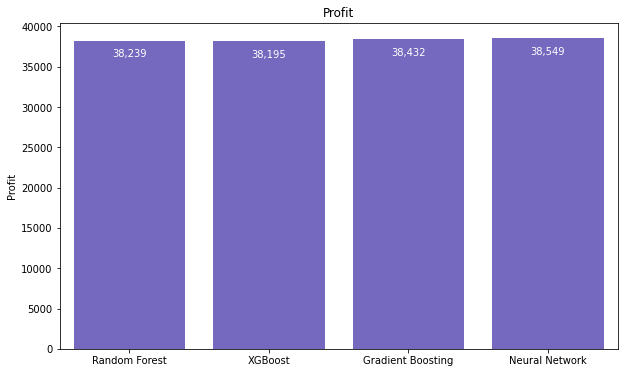

In [66]:
# plot for profit
plt.figure(figsize=(10, 6))
fig = sns.barplot(x="Name", y="Profit", color="slateblue", data=profit_rome_df)
fig.set(xlabel="", ylabel="Profit", title="Profit")
for index, row in profit_rome_df.iterrows():
    fig.text(
        row.name, row.Profit - 2000, f"{int(row.Profit):,}", ha="center", color="white"
    )

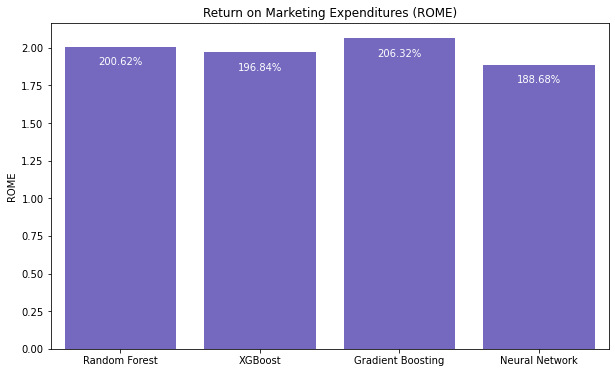

In [65]:
# plot for rome
plt.figure(figsize=(10, 6))
fig = sns.barplot(x="Name", y="ROME", color="slateblue", data=profit_rome_df)
fig.set(xlabel="", ylabel="ROME", title="Return on Marketing Expenditures (ROME)")
for index, row in profit_rome_df.iterrows():
    fig.text(
        row.name,
        row.ROME - 0.12,
        f"{round((100*row.ROME), 2):,}%",
        ha="center",
        color="white",
    )

### Gains, lifts (and AUC)

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

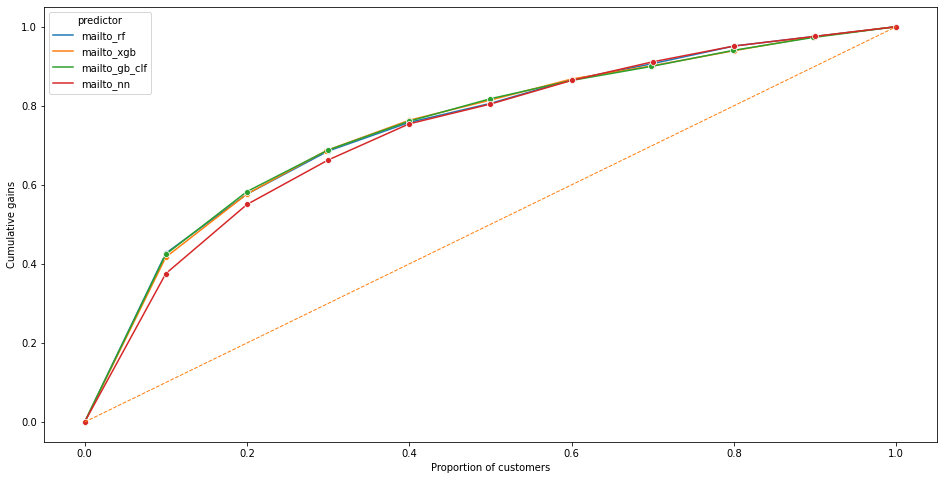

In [54]:
# gains
plt.figure(figsize=(16, 8))
rsm.gains_plot(
    result_df,
    rvar="res1",
    lev="Yes",
    pred=[
        "mailto_rf",
        "mailto_xgb",
        "mailto_gb_clf",
        "mailto_nn",
    ],
    qnt=10,
    marker="o",
)

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative lift'>

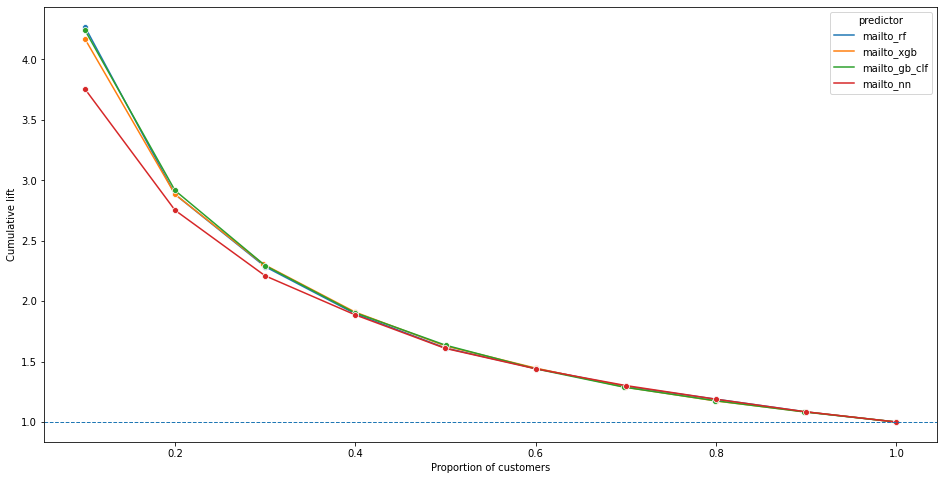

In [55]:
# lifts
plt.figure(figsize=(16, 8))
rsm.lift_plot(
    result_df,
    rvar="res1",
    lev="Yes",
    pred=[
        "mailto_rf",
        "mailto_xgb",
        "mailto_gb_clf",
        "mailto_nn",
    ],
    qnt=10,
    marker="o",
)

In [56]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    result_df["res1_yes"], result_df["mailto_rf"], pos_label=1
)
auc_rf = auc(fpr_rf, tpr_rf)

In [57]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    result_df["res1_yes"], result_df["mailto_xgb"], pos_label=1
)
auc_xgb = auc(fpr_xgb, tpr_xgb)

In [58]:
fpr_gb_clf, tpr_gb_clf, thresholds_gb_clf = roc_curve(
    result_df["res1_yes"], result_df["mailto_gb_clf"], pos_label=1
)
auc_gb_clf = auc(fpr_gb_clf, tpr_gb_clf)

In [59]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(
    result_df["res1_yes"], result_df["mailto_nn"], pos_label=1
)
auc_nn = auc(fpr_nn, tpr_nn)

In [63]:
auc_df = pd.DataFrame(
    {
        "Name": [
            "Random Forest",
            "XGBoost",
            "Gradient Boosting",
            "Neural Network",
        ],
        "AUC": [
            auc_rf,
            auc_xgb,
            auc_gb_clf,
            auc_nn,
        ],
    }
)
auc_df

,Name,AUC
0,Random Forest,0.767819
1,XGBoost,0.767017
2,Gradient Boosting,0.768493
3,Neural Network,0.754618


### Anticipate profit in Wave-2 and generate csv

Based on the performances above, we decide to use Gradient Boosting.

In [12]:
profit_w2_gb_clf = functions.profit_wave2(
    intuit75k_copy_test, col="mailto_gb_clf", intro="By using Gradient boosting"
)

By using Gradient boosting, the anticipate profit in Wave-2 will be $458655.


In [11]:
# predict probability for Wave-2
wave2 = intuit75k_copy_test.query("res1_yes == 0").copy()

scalar = StandardScaler()
sf1 = scalar.fit(wave2[["numords"]])
sf2 = scalar.fit(wave2[["last"]])
wave2["numords"] = sf1.transform(wave2[["numords"]])
wave2["last"] = sf2.transform(wave2[["last"]])

wave2["mailto_wave2"] = (
    gb_clf.predict_proba(
        pd.get_dummies(
            wave2[cols],
            drop_first=True,
        )
    )[:, 1]
    * 0.5
    > 0.0235
)

In [13]:
# Generate the CSV
result = pd.merge(
    intuit75k_copy_test[["id"]].copy(),
    wave2[["id", "mailto_wave2"]],
    on="id",
    how="left",
).fillna(False)

# Check for merger
# (
#     result.loc[result["mailto_wave2"] == True, "id"].values
#     != wave2.loc[wave2["mailto_wave2"] == True, "id"].values
# ).sum()

result.to_csv("Yinluo_Zezheng_Yuquan_Shangfu_Anaconda.csv", index=False)